# A comparison of the instrument noise calculation in Tools21cm against 21cmSense

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
from tqdm import tqdm
from glob import glob
from time import time

In [3]:
from astropy import units as un
from astropy.cosmology import Planck15

## 21cmSense

In [4]:
import py21cmsense as p21sense
from py21cmsense.observatory import Observatory
from py21cmsense.sensitivity import PowerSpectrum
from py21cmsense.theory import EOS2021

Here we define some helper functions. `get_senses` is a function that takes in a `21cmSense.Observation` instance, the frequency bands of the survey, as well as the $k_\bot, k_\parallel$ bins at which we want the sensitivities. This function simply loops over each band and calculates the sensitivity of the given observation at that band and $k_\bot, k_\parallel$ bins.

In [5]:
def freq2z(f):
    """Convert frequency in MHz to redshift."""
    return 1420.4 / f - 1.0


def z2freq(z):
    """Convert redshift to frequency in MHz."""
    return 1420.4 / (z + 1.0)


def get_senses(
    observation,
    freq_bands,
    kperp_edges_hmpc,
    kpar_edges_hmpc,
    calc_2d=False,
    foreground_model="moderate",
    theory_model=EOS2021,
    **kwargs,
):
    """Calculate the sensitivity for a set of frequency bands."""
    h = observation.cosmo.H0.value / 100.0
    redshifts = kwargs["redshifts"]
    mock_senses = {}
    mock_senses["kperp_edges_hMpc"] = kperp_edges_hmpc
    mock_senses["kpar_edges_hMpc"] = kpar_edges_hmpc
    mock_senses["redshifts"] = redshifts
    mock_senses["freq_bands"] = freq_bands
    mock_senses["h"] = h

    for _i, band, zval in zip(range(len(freq_bands)), freq_bands, redshifts):
        this_z = {}
        band_name = str(np.round(band, 1)) + " MHz"

        sense = PowerSpectrum(
            observation=observation, foreground_model=foreground_model, theory_model=theory_model()
        ).at_frequency(band * un.MHz)
        if calc_2d:
            sense2d_sample = sense.calculate_sensitivity_2d_grid(
                kperp_edges=kperp_edges_hmpc, kpar_edges=kpar_edges_hmpc, thermal=False, sample=True
            )
            this_z["sample_2D_mK2"] = sense2d_sample.value

            sense2d_thermal = sense.calculate_sensitivity_2d_grid(
                kperp_edges=kperp_edges_hmpc, kpar_edges=kpar_edges_hmpc, thermal=True, sample=False
            )
            this_z["thermal_2D_mK2"] = sense2d_thermal.value

            both = np.sqrt(sense2d_sample.value**2 + sense2d_thermal.value**2)
            this_z["sample_and_thermal_2D_mK2"] = both

        sense1d_sample = sense.calculate_sensitivity_1d(thermal=False, sample=True)
        this_z["sample_1D_mK2"] = sense1d_sample.value
        this_z["theory_1D_mK2"] = sense.theory_model.delta_squared(
            zval, sense.k1d.value * mock_senses["h"]
        ).value

        this_z["k_1D_Mpc"] = sense.k1d.value * mock_senses["h"]
        sense1d_thermal = sense.calculate_sensitivity_1d(thermal=True, sample=False)
        this_z["thermal_1D_mK2"] = sense1d_thermal.value

        sense1d_both = sense.calculate_sensitivity_1d(thermal=True, sample=True)
        this_z["sample_and_thermal_1D_mK2"] = sense1d_both.value
        mock_senses[band_name] = this_z
    return mock_senses


### Define the Observatories for each SKA configuration

We will produce sensitivity estimates for two SKA configurations: AA* and AA4.

In [6]:
aaast = Observatory.from_ska("AA*")
aa4 = Observatory.from_ska("AA4")

The two configurations differ from each other in the following ways:  
- **AA4** has more stations (512) than **AA*** (307).  
- **AA4** has more stations clustered at the center than **AA***.  

Let’s check this by plotting the station layouts of each experiment:

AA* has 307 antennas
AA4 has 512 antennas


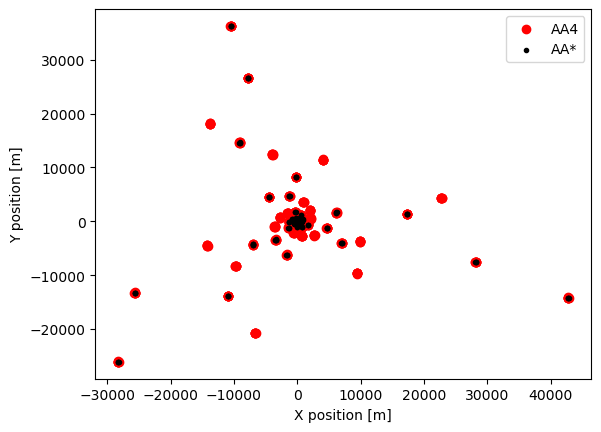

In [7]:
aaast_antpos = aaast.antpos.value[:, :2]  # exclude z position
aa4_antpos = aa4.antpos.value[:, :2]  # exclude z position
print("AA* has", aaast_antpos.shape[0], "antennas")
print("AA4 has", aa4_antpos.shape[0], "antennas")
plt.scatter(aa4_antpos[:, 0], aa4_antpos[:, 1], label="AA4", color="r")
plt.scatter(aaast_antpos[:, 0], aaast_antpos[:, 1], label="AA*", color="k", marker=".")
plt.legend()
plt.ylabel("Y position [m]")
plt.xlabel("X position [m]")
plt.show()

We can also plot the baseline distribution produced by each experiment:

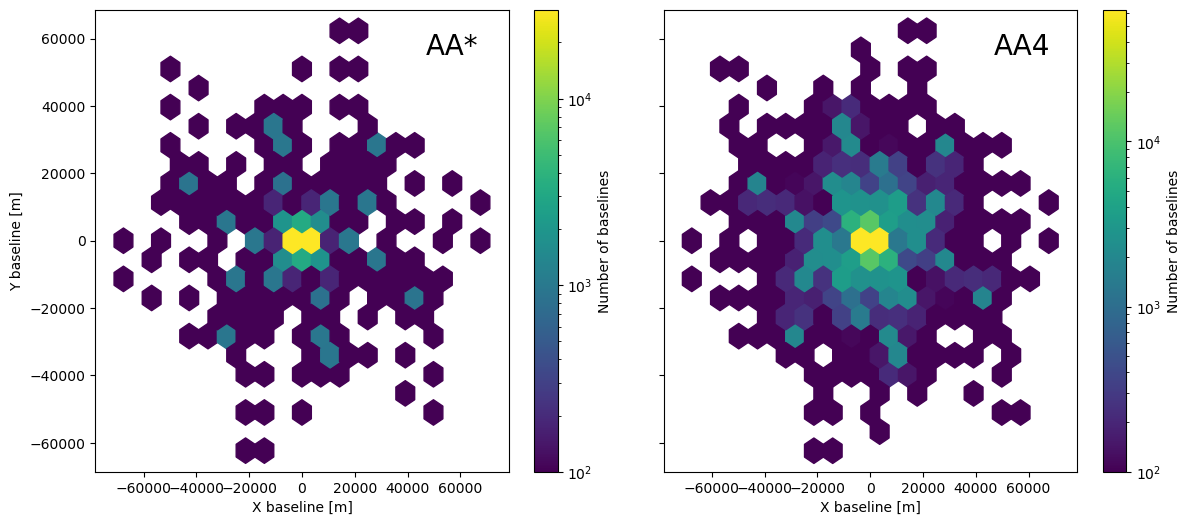

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1})
im = ax[0].hexbin(
    aaast.baselines_metres[:, :, 0].ravel(),
    aaast.baselines_metres[:, :, 1].ravel(),
    label="AA*",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[0], label="Number of baselines")
im = ax[1].hexbin(
    aa4.baselines_metres[:, :, 0].ravel(),
    aa4.baselines_metres[:, :, 1].ravel(),
    label="AA4",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[1], label="Number of baselines")
ax[0].set_xlabel("X baseline [m]")
ax[1].set_xlabel("X baseline [m]")
ax[0].set_ylabel("Y baseline [m]")
ax[0].text(0.8, 0.95, "AA*", transform=ax[0].transAxes, fontsize=20, verticalalignment="top")
ax[1].text(0.8, 0.95, "AA4", transform=ax[1].transAxes, fontsize=20, verticalalignment="top")
plt.show()

This plot shows us that while we have a very wide range of baselines available, the baseline density is highest at shorter baselines due to the clustering of the stations. Let’s zoom in on this region:

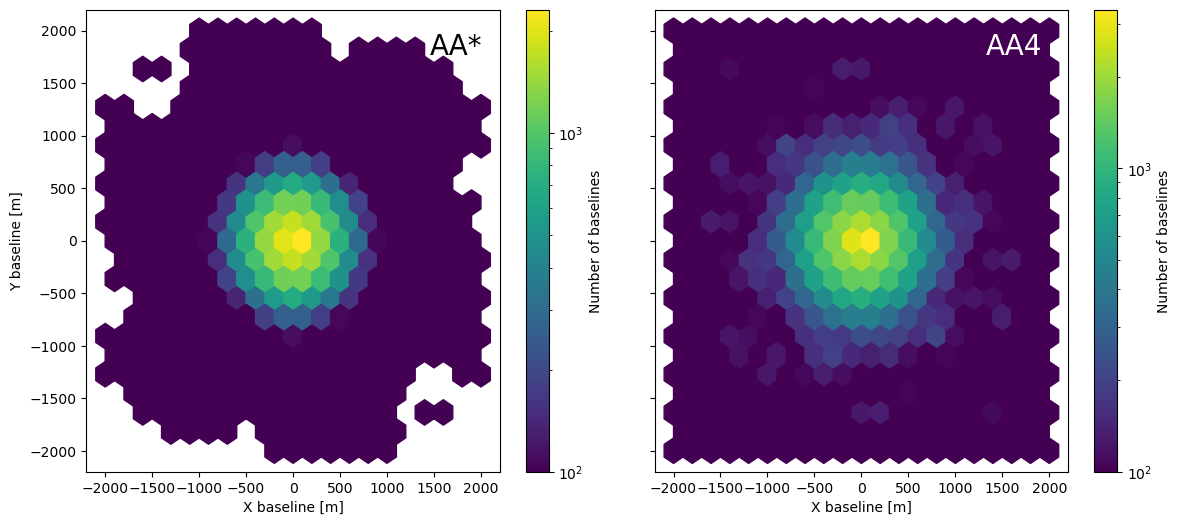

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1})
m = np.logical_and(
    abs(aaast.baselines_metres[:, :, 0].ravel().value) < 2000,
    abs(aaast.baselines_metres[:, :, 1].ravel().value) < 2000,
)
im = ax[0].hexbin(
    aaast.baselines_metres[:, :, 0].ravel()[m],
    aaast.baselines_metres[:, :, 1].ravel()[m],
    label="AA*",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[0], label="Number of baselines")
m = np.logical_and(
    abs(aa4.baselines_metres[:, :, 0].ravel().value) < 2000,
    abs(aa4.baselines_metres[:, :, 1].ravel().value) < 2000,
)
im = ax[1].hexbin(
    aa4.baselines_metres[:, :, 0].ravel()[m],
    aa4.baselines_metres[:, :, 1].ravel()[m],
    label="AA4",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[1], label="Number of baselines")
ax[0].set_xlabel("X baseline [m]")
ax[1].set_xlabel("X baseline [m]")
ax[0].set_ylabel("Y baseline [m]")
ax[0].text(0.83, 0.95, "AA*", transform=ax[0].transAxes, fontsize=20, verticalalignment="top")
ax[1].text(
    0.8, 0.95, "AA4", transform=ax[1].transAxes, fontsize=20, verticalalignment="top", color="w"
)
plt.show()

In [15]:
freq_bands = np.array([60.0, 80.0, 120.0, 125.0, 140.0, 160.0, 180.0, 200.0, 215.0])  # MHz
zs = freq2z(freq_bands)

observation_params = {}
observation_params["ndays"] = 1.0 #180.0
observation_params["cosmo"] = Planck15
observation_params["h"] = Planck15.H0.value / 100.0
observation_params["freq_bands"] = freq_bands
observation_params["redshifts"] = zs
observation_params["time_per_day_hrs"] = 6.0

In [16]:
# Only needed if we want to calculate the 2D sensitivity
# Set the kperp and kpar bins at which we want to calculate the 2D sensitivity
sense_params = {}
sense_params["calc_2d"] = True
sense_params["foreground_model"] = "moderate"
sense_params["redshifts"] = zs
sense_params["freq_bands"] = freq_bands
sense_params["kperp_edges_hmpc"] = un.Quantity(np.logspace(-1.5, 0.3, 15), "littleh/Mpc")
sense_params["kpar_edges_hmpc"] = un.Quantity(np.logspace(-1.5, 0.3, 15), "littleh/Mpc")
sense_params["kpar_mpc"] = (
    np.exp(
        (
            np.log(sense_params["kpar_edges_hmpc"].value[:-1])
            + np.log(sense_params["kpar_edges_hmpc"].value[1:])
        )
        / 2
    )
    * observation_params["h"]
)
sense_params["kperp_mpc"] = (
    np.exp(
        (
            np.log(sense_params["kperp_edges_hmpc"].value[:-1])
            + np.log(sense_params["kperp_edges_hmpc"].value[1:])
        )
        / 2
    )
    * observation_params["h"]
)

In [17]:
obs = p21sense.Observation(
    observatory=aa4,
    lst_bin_size=observation_params["time_per_day_hrs"] * un.hour,
    time_per_day=observation_params["time_per_day_hrs"] * un.hour,
    n_days=observation_params["ndays"],
    cosmo=observation_params["cosmo"],
    coherent=True,
    # To point to dish off-zenith, use: phase_center_dec=-30.0*un.deg,
    # max baseline is 73km and there are ~260k bls so the gridding takes a very long time.
    # we add a baseline filer to only keep baselines up to 1km.
    baseline_filters=p21sense.BaselineRange(bl_max=1e3 * un.m),
)

ska_aa4_senses1 = get_senses(
    obs,
    **sense_params, 
)


averaging to 1D: 100%|██████████| 268/268 [00:00<00:00, 346.11kperp-bins/s]
/var/folders/wv/qwzjbf6s2c3cghfssgh619600000gr/T/ipykernel_10739/2183934006.py:54: UserWarning: Extrapolating above the simulated theoretical k: 3.4156411667123066 > 3.3903453170721027
  this_z["theory_1D_mK2"] = sense.theory_model.delta_squared(
averaging to 1D: 100%|██████████| 280/280 [00:00<00:00, 349.23kperp-bins/s]
/var/folders/wv/qwzjbf6s2c3cghfssgh619600000gr/T/ipykernel_10739/2183934006.py:54: UserWarning: Extrapolating above the simulated theoretical k: 3.571225571913334 > 3.3903453170721027
  this_z["theory_1D_mK2"] = sense.theory_model.delta_squared(
averaging to 1D: 100%|██████████| 277/277 [00:00<00:00, 341.57kperp-bins/s]
/var/folders/wv/qwzjbf6s2c3cghfssgh619600000gr/T/ipykernel_10739/2183934006.py:54: UserWarning: Extrapolating above the simulated theoretical k: 3.819178942600253 > 3.3903453170721027
  this_z["theory_1D_mK2"] = sense.theory_model.delta_squared(
averaging to 1D: 100%|██████████|

In [18]:
obs = obs.clone(observatory=aaast)

ska_aaast_senses1 = get_senses(
    obs,
    **sense_params, 
)

averaging to 1D: 100%|██████████| 265/265 [00:00<00:00, 342.17kperp-bins/s]
/var/folders/wv/qwzjbf6s2c3cghfssgh619600000gr/T/ipykernel_10739/2183934006.py:54: UserWarning: Extrapolating above the simulated theoretical k: 3.4156411667123066 > 3.3903453170721027
  this_z["theory_1D_mK2"] = sense.theory_model.delta_squared(
averaging to 1D: 100%|██████████| 278/278 [00:00<00:00, 331.19kperp-bins/s]
/var/folders/wv/qwzjbf6s2c3cghfssgh619600000gr/T/ipykernel_10739/2183934006.py:54: UserWarning: Extrapolating above the simulated theoretical k: 3.571225571913334 > 3.3903453170721027
  this_z["theory_1D_mK2"] = sense.theory_model.delta_squared(
averaging to 1D: 100%|██████████| 274/274 [00:00<00:00, 329.98kperp-bins/s]
/var/folders/wv/qwzjbf6s2c3cghfssgh619600000gr/T/ipykernel_10739/2183934006.py:54: UserWarning: Extrapolating above the simulated theoretical k: 3.819178942600253 > 3.3903453170721027
  this_z["theory_1D_mK2"] = sense.theory_model.delta_squared(
averaging to 1D: 100%|██████████|

gridding baselines: 100%|██████████| 44226/44226 [00:03<00:00, 13103.04baselines/s]


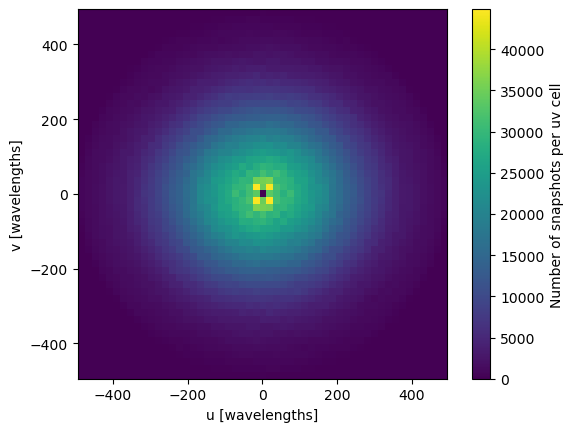

In [19]:
plt.imshow(obs.uv_coverage, extent=(obs.ugrid.min(), obs.ugrid.max()) * 2)
ax = plt.colorbar()
ax.set_label("Number of snapshots per uv cell")
plt.xlabel("u [wavelengths]")
plt.ylabel("v [wavelengths]");

## Tools21cm

In [10]:
import tools21cm as t2c

/Users/sambit/miniconda3/envs/HM/lib/python3.10/site-packages/skimage/util/dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


In [11]:
aastar_layout = t2c.get_SKA_Low_layout(subarray_type="AA*")
aa4_layout = t2c.get_SKA_Low_layout(subarray_type="AA4")

AA* contains 307 antennae.
AA4 contains 512 antennae.


(307, 3)
(512, 3)


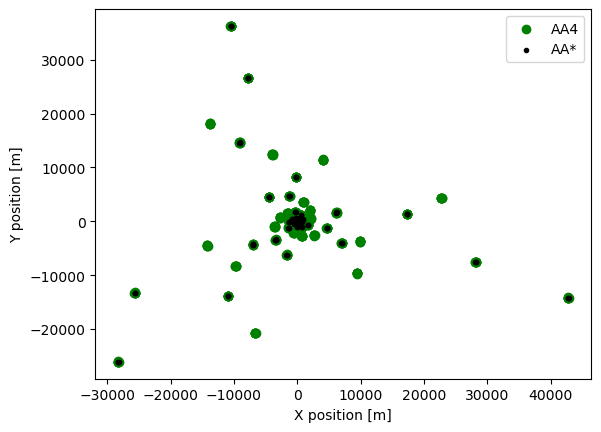

In [12]:
print(aastar_layout.shape)
print(aa4_layout.shape)

plt.scatter(aa4_layout[:, 0], aa4_layout[:, 1], label="AA4", color="g")
plt.scatter(aastar_layout[:, 0], aastar_layout[:, 1], label="AA*", color="k", marker=".")
plt.legend()
plt.ylabel("Y position [m]")
plt.xlabel("X position [m]")
plt.show()

In [13]:
aastar_baselines = t2c.antenna_positions_to_baselines(aastar_layout)
aa4_baselines = t2c.antenna_positions_to_baselines(aa4_layout)
print(aastar_baselines.shape, aa4_baselines.shape)

93942it [00:00, 183059.59it/s]
261632it [00:01, 204826.08it/s]


(93942, 3) (261632, 3)


In [14]:
type(aastar_layout),  type(aastar_baselines), aastar_baselines[0,0]

(astropy.units.quantity.Quantity,
 astropy.units.quantity.Quantity,
 <Quantity 307.486232 m>)

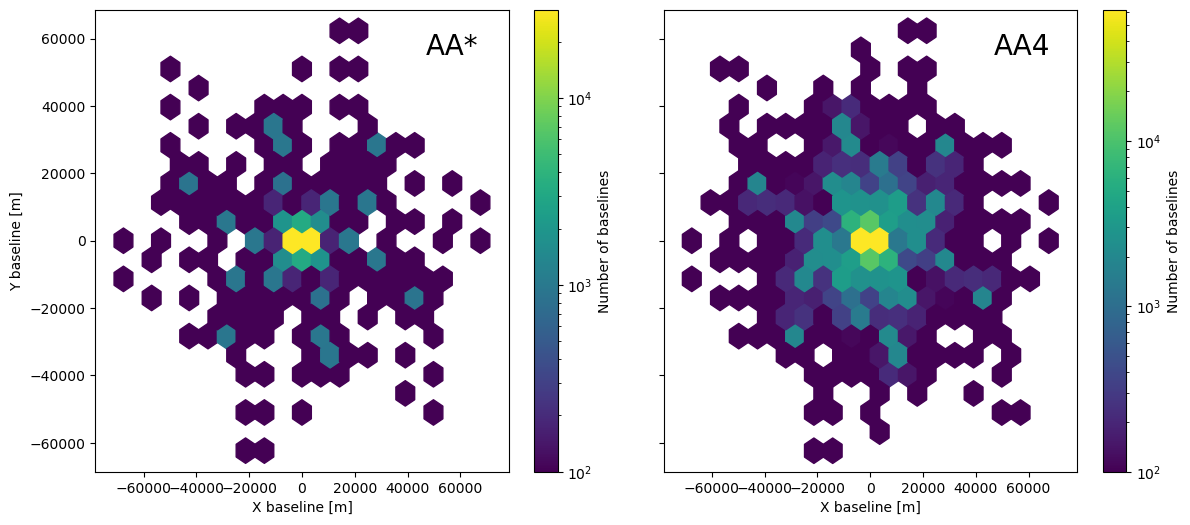

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1})
im = ax[0].hexbin(
    aastar_baselines[:, 0], 
    aastar_baselines[:, 1],
    label="AA*",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[0], label="Number of baselines")
im = ax[1].hexbin(
    aa4_baselines[:, 0], 
    aa4_baselines[:, 1],
    label="AA4",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[1], label="Number of baselines")
ax[0].set_xlabel("X baseline [m]")
ax[1].set_xlabel("X baseline [m]")
ax[0].set_ylabel("Y baseline [m]")
ax[0].text(0.8, 0.95, "AA*", transform=ax[0].transAxes, fontsize=20, verticalalignment="top")
ax[1].text(0.8, 0.95, "AA4", transform=ax[1].transAxes, fontsize=20, verticalalignment="top")
plt.show()

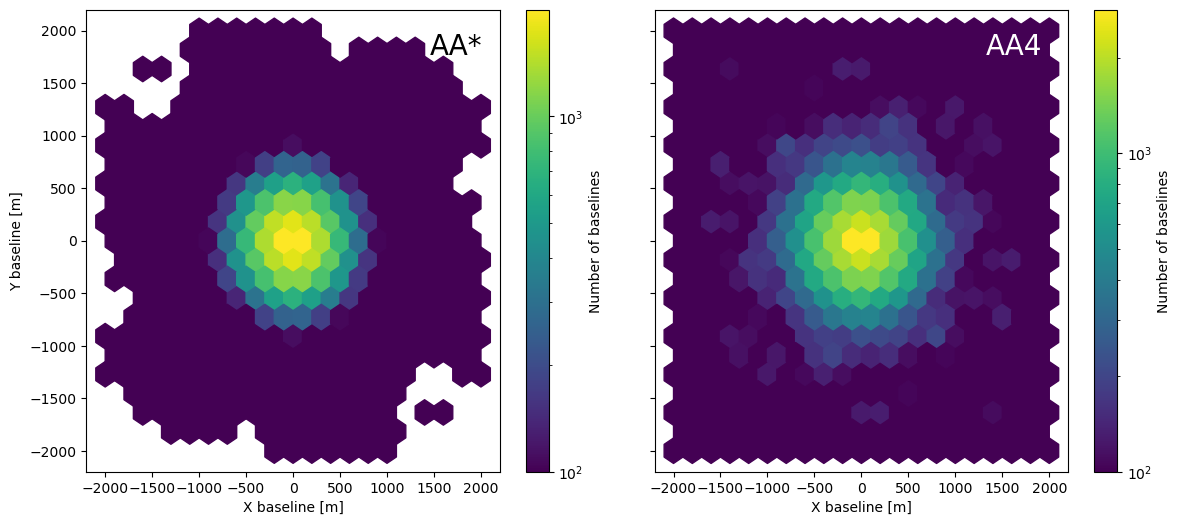

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1})
m = np.logical_and(
    abs(aastar_baselines[:,0].value) < 2000,
    abs(aastar_baselines[:,1].value) < 2000,
)
im = ax[0].hexbin(
    aastar_baselines[:,0][m],
    aastar_baselines[:,1][m],
    label="AA*",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[0], label="Number of baselines")
m = np.logical_and(
    abs(aa4_baselines[:,0].value) < 2000,
    abs(aa4_baselines[:,1].value) < 2000,
)
im = ax[1].hexbin(
    aa4_baselines[:,0][m],
    aa4_baselines[:,1][m],
    label="AA4",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[1], label="Number of baselines")
ax[0].set_xlabel("X baseline [m]")
ax[1].set_xlabel("X baseline [m]")
ax[0].set_ylabel("Y baseline [m]")
ax[0].text(0.83, 0.95, "AA*", transform=ax[0].transAxes, fontsize=20, verticalalignment="top")
ax[1].text(
    0.8, 0.95, "AA4", transform=ax[1].transAxes, fontsize=20, verticalalignment="top", color="w"
)
plt.show()